### 1.
Intraday on-shore wind power generation measured every hour for one year is available from the csv file WindGeneration.csv. Load the data into your computer and produce a graphic showing the time series of the wind generation over time. Is there evidence of annual seasonality?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
import time
import warnings

warnings.filterwarnings(action='once')

wind = read_csv(
    'WindGeneration.csv', header=0, encoding="latin1", na_values=['-'])

colDict = {}
for l in list(wind):
    colDict[l] = l.replace('Wind ', '')

wind.rename(index=str, columns=colDict, inplace=True)

wind.interpolate(inplace=True)

d = wind.loc[:, 'Date'].tolist()
t = wind.loc[:, 'Time'].tolist()

for i in range(len(t)):
    if len(str(t[i])) < 2:
        t[i] = "0" + str(t[i])
    else:
        t[i] = str(t[i])
    if t[i] == "24":
        t[i] = "00"

pattern = "%d/%m/%Y:%H"
dateTime = []
for i in range(len(d)):
    DT = "{}:{}".format(d[i], t[i])
    strp = time.strptime(DT, pattern)
    DT = time.strftime(pattern, strp)
    dateTime.append(DT)

wind['DateTime'] = pd.Series(dateTime, index=wind.index)
wind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 4 columns):
Date          8760 non-null object
Time          8760 non-null int64
Generation    8760 non-null float64
DateTime      8760 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 342.2+ KB


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

N = len(wind["Generation"])
ind = np.arange(N)


def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, N - 1)
    return wind["Date"][thisind]

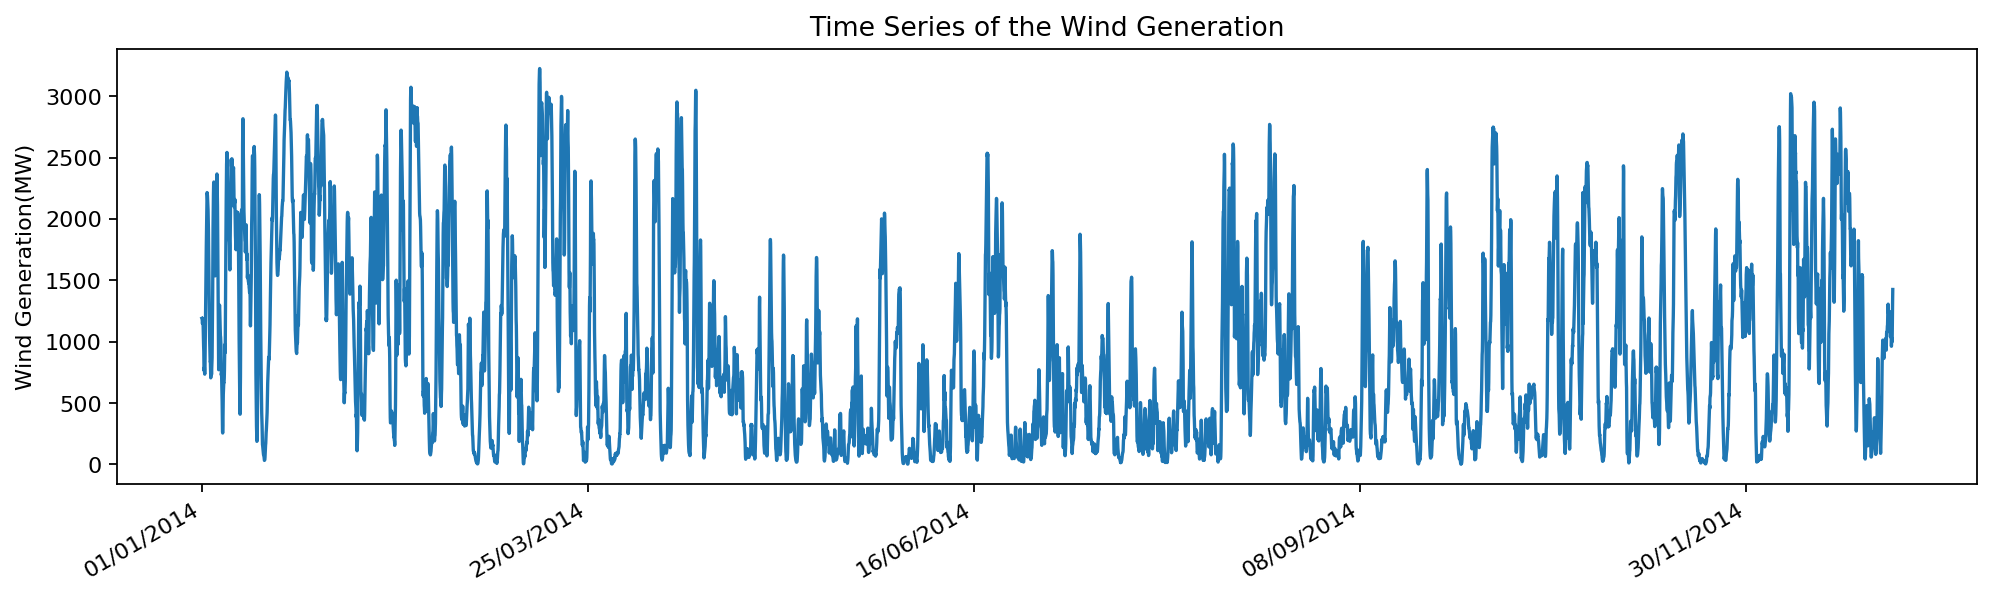

In [3]:
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
ax.plot(ind, wind["Generation"])
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

ax.set_ylabel('Wind Generation(MW)')
ax.set_title("Time Series of the Wind Generation")
fig.autofmt_xdate()

plt.show()

### 2.
Plot the change in wind generation over time as a percentage of the maximum generation. Is there evidence of annual seasonality?

In [4]:
def get_ramp(x, d):
    N = len(x)
    ramp = []
    for i in range(N):
        if i < d:
            ramp.append(np.NaN)
        else:
            ramp.append(round((x[i] - x[i - d]) / max(x) * 100, 4))
    return ramp


ramp = get_ramp(wind["Generation"], 1)

wind['Ramp'] = pd.Series(ramp, index=wind.index) # (%)

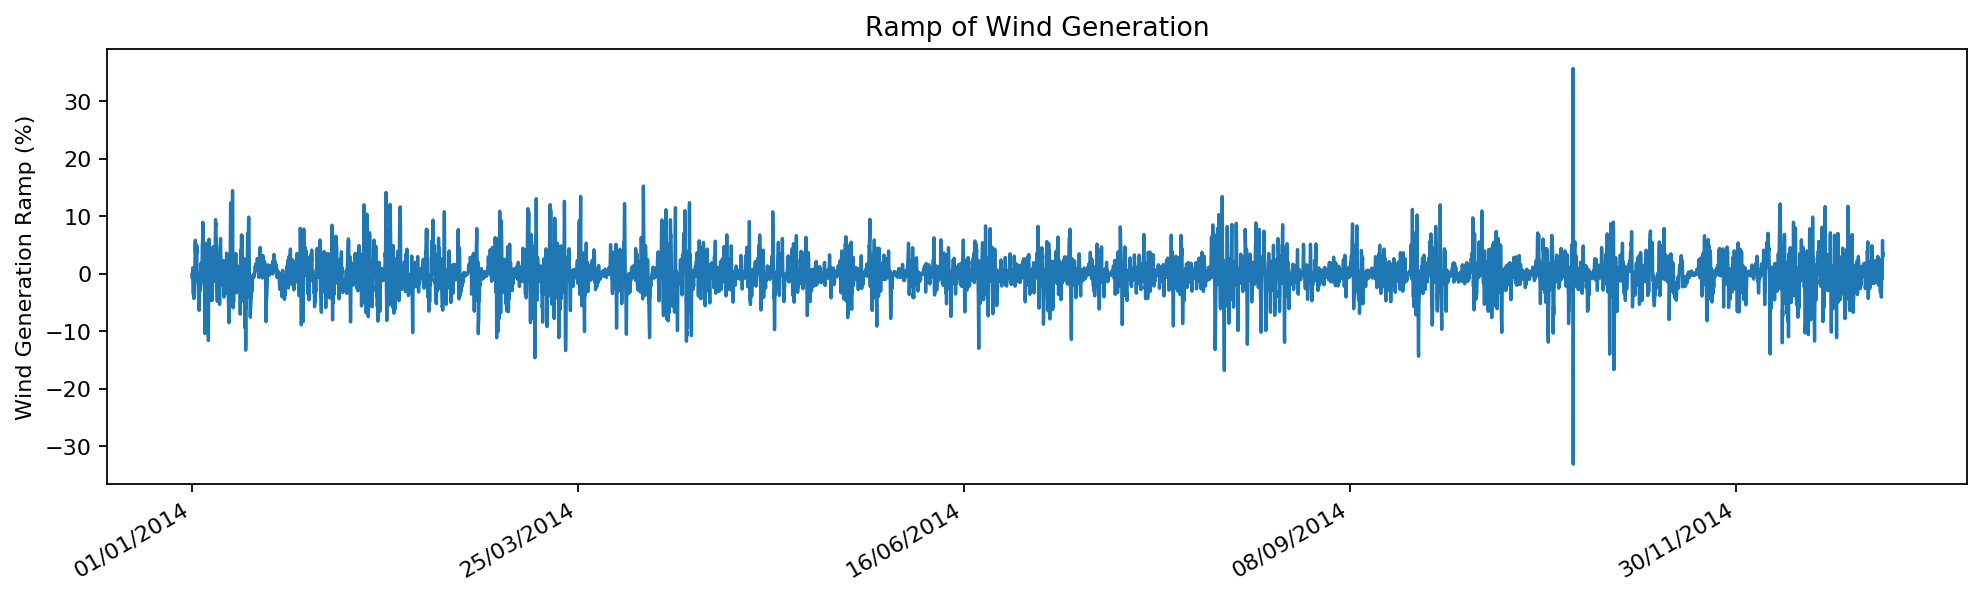

In [5]:
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
ax.plot(ind, ramp)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

ax.set_ylabel('Wind Generation Ramp (%)')
ax.set_title("Ramp of Wind Generation")
fig.autofmt_xdate()

plt.show()

### 3. 
Consider positive and negative ramps in wind power generation, x(t), as a percentage of the maximum, over the hourly timescale. An hourly ramp is therefore defined as **r(t,d) =100*[x(t+d)- x(t)]/max(x)** where d=1 for an hourly sampling period. Construct empirical **cumulative distribution functions (CDF)** for both the positive and negative ramps and plot these with the probability on a vertical logarithmic axis. Plot the CDF for a normal distribution with mean-zero and standard deviation from the observations. Is the normal distribution a good model for wind power extremes?

In [6]:
pramp = []
nramp = []
for r in ramp:
    if r > 0:
        pramp.append(r)
    elif r < 0:
        nramp.append(r)

Np = len(pramp)
Nn = len(nramp)

X = np.sort(nramp).tolist()
X = X + np.sort(pramp).tolist()

F = np.append(np.array(range(Nn)) / float(Nn), np.array(range(Np-1,-1,-1)) / float(Np))

### Normal Distribution
sigma = np.std(ramp[1:])
s = np.random.normal(0, sigma, N - 1)
ps = []
ns = []
for r in s:
    if r > 0:
        ps.append(r)
    elif r < 0:
        ns.append(r)
Nps = len(ps)
Nns = len(ns)

S = np.sort(ns).tolist()
S = S + np.sort(ps).tolist()
F1 = np.append(np.array(range(Nns)) / float(Nns), np.array(range(Nps-1,-1,-1)) / float(Nps))

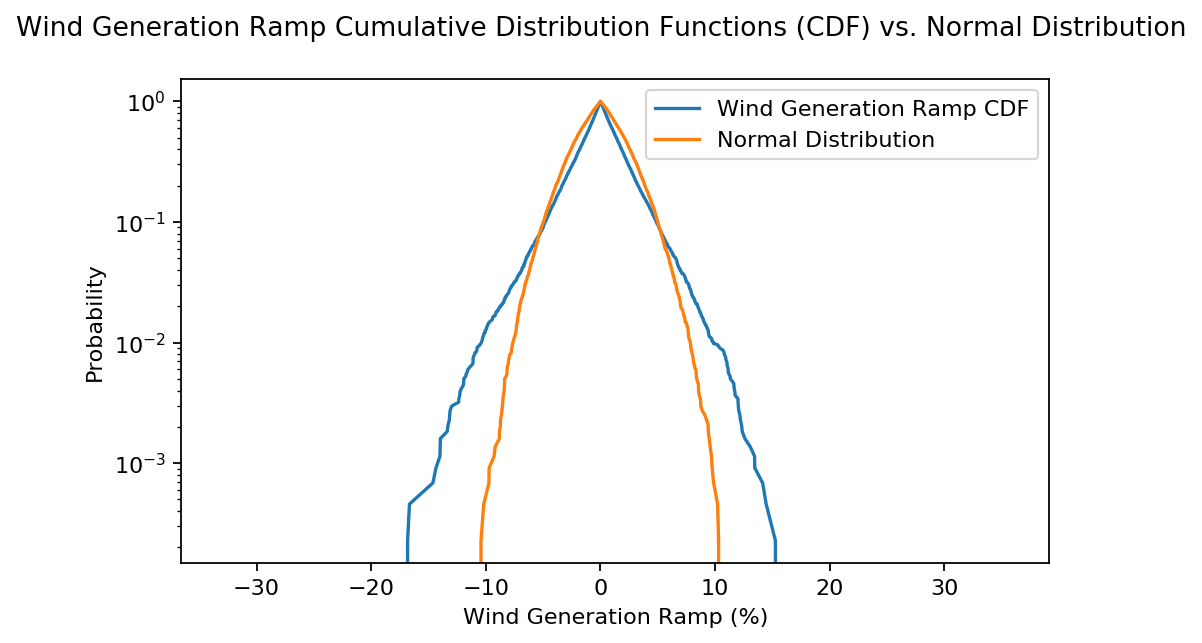

In [7]:
fig, ax = plt.subplots(figsize=(7,4), dpi=80)

ax.set_xlabel('Wind Generation Ramp (%)')
ax.set_ylabel('Probability')

ax.plot(X, F, label="Wind Generation Ramp CDF")
ax.plot(S, F1, label="Normal Distribution")
ax.set_yscale('log')

ax.legend()
fig.suptitle(
    "Wind Generation Ramp Cumulative Distribution Functions (CDF) vs. Normal Distribution"
)
plt.show()

### 4. 
National power system operators are tasked with the challenge of balancing supply and demand. They need to understand the variability in wind generation over different timescales. Investigate variability over timescales from one hour to one day by plotting the 1%, 5%, 95% and 99% percentiles. This can be achieved using distributions of the ramps r(t,d) with d =1,2,...,24.


In [8]:
def get_percentile(x, d_start, d_stop, quantiles):
    N = len(x)
    ramps_df = pd.DataFrame()
    
    for d in range(d_start, d_stop + 1):
        ramps = []
        for i in range(N):
            if i >= d:
                ramps.append(round((x[i] - x[i - d]) / max(x) * 100, 4))
        
        ramps_df["{}".format(d)] = pd.Series(ramps)
        
    ramps_np = ramps_df.values.T
    percentiles = []
    for q in quantiles:
        percentiles.append(np.nanpercentile(ramps_np, q, axis=1))
        
    return ramps_df, percentiles

quantiles = [1, 5, 95, 99]
ramps_df, percentiles = get_percentile(wind["Generation"], 1, 24, quantiles)

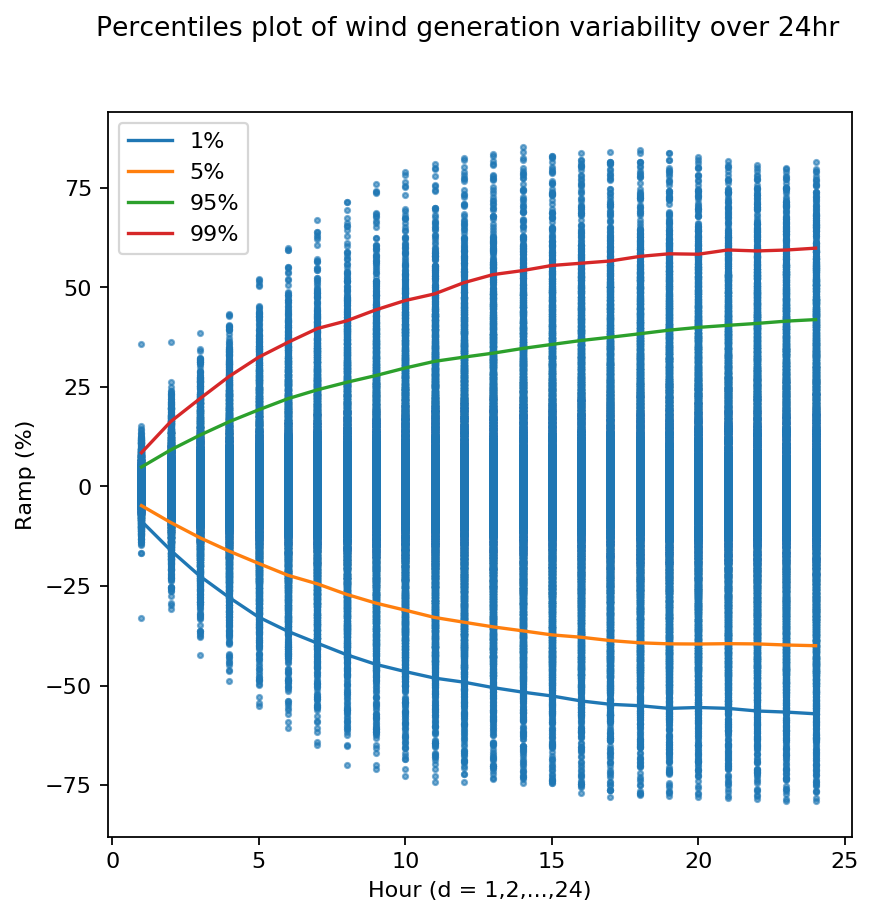

In [9]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=80)

for c in ramps_df.columns:
    y = ramps_df[c].tolist()
    x = [int(c)] * len(y)

    ax.scatter(x, y, color='C0', alpha=0.6, s=5)

_x = range(1, 25)

for i, q in enumerate(quantiles):
    #     # Plot the quantile lines
    _y = percentiles[i]
    ax.plot(_x, _y, label="{}%".format(q))

ax.legend()
ax.set_xlabel('Hour (d = 1,2,...,24)')
ax.set_ylabel('Ramp (%)')
fig.suptitle("Percentiles plot of wind generation variability over 24hr")

plt.show()

### 5. 
Calculate and plot the autocorrelation of wind generation for lags over 10 days. Comment on the structure of the autocorrelation.

/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])


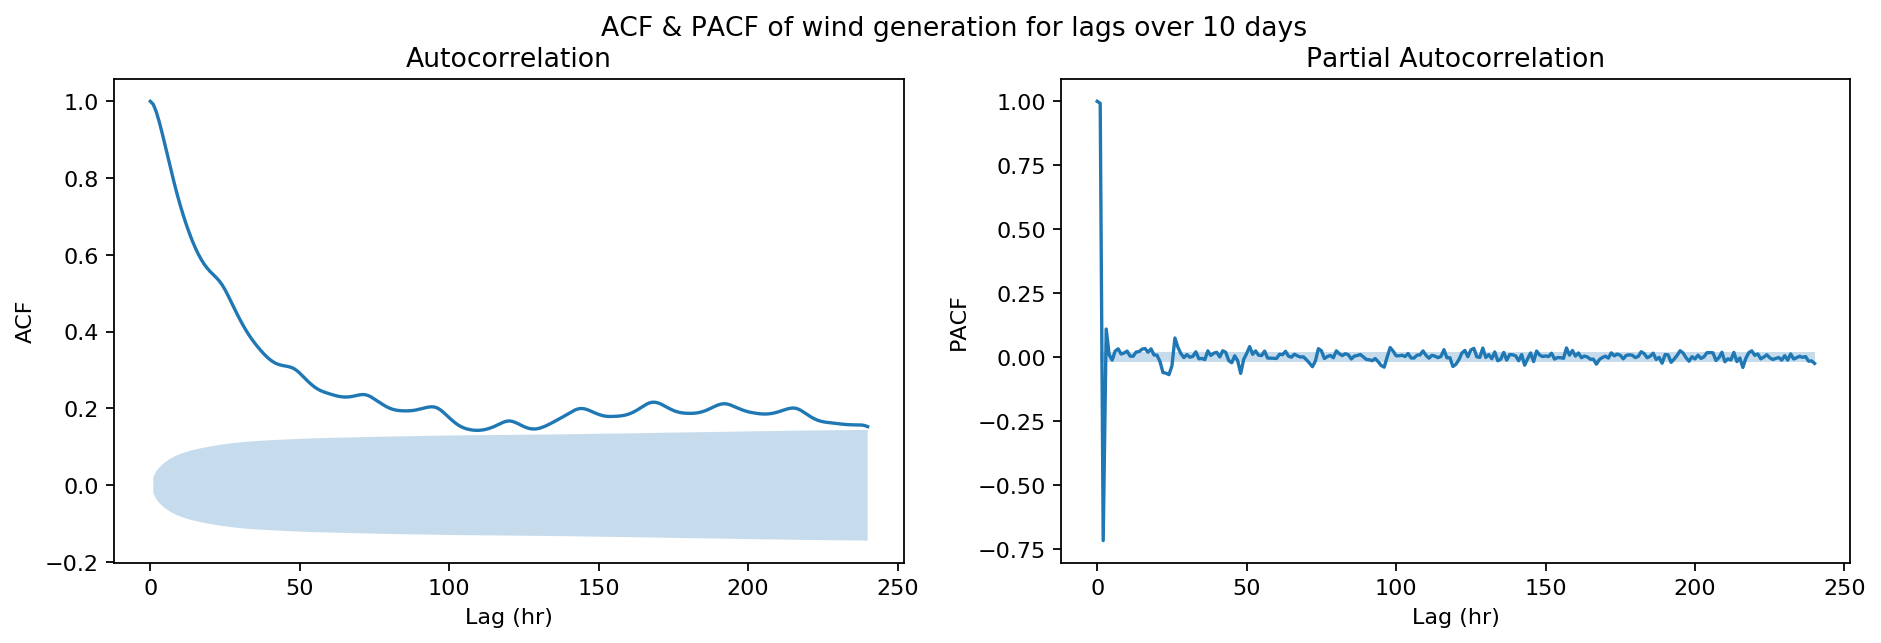

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### ACF
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14,4),dpi=80)

ax = axes[0]
ax.set_xlabel('Lag (hr)')
ax.set_ylabel('ACF')

plotAcf = plot_acf(
    wind["Generation"],
    lags=240,
    alpha=0.05,
    ax=ax,
    use_vlines=False,
    markersize=0,
    linestyle='-')

### PACF
ax = axes[1]

ax.set_xlabel('Lag (hr)')
ax.set_ylabel('PACF')

plotAcf = plot_pacf(
    wind["Generation"],
    lags=240,
    alpha=0.05,
    ax=ax,
    use_vlines=False,
    markersize=0,
    linestyle='-')

fig.suptitle("ACF & PACF of wind generation for lags over 10 days")
plt.show()

### 6. 
Calculate and plot the autocorrelation of change in wind generation for lags over 10 days. Include horizontal lines to detect statistically significance values (p<0.05). Is there any evidence of diurnal seasonality? Might it be more appropriate to model the change in wind generation than the wind generation?

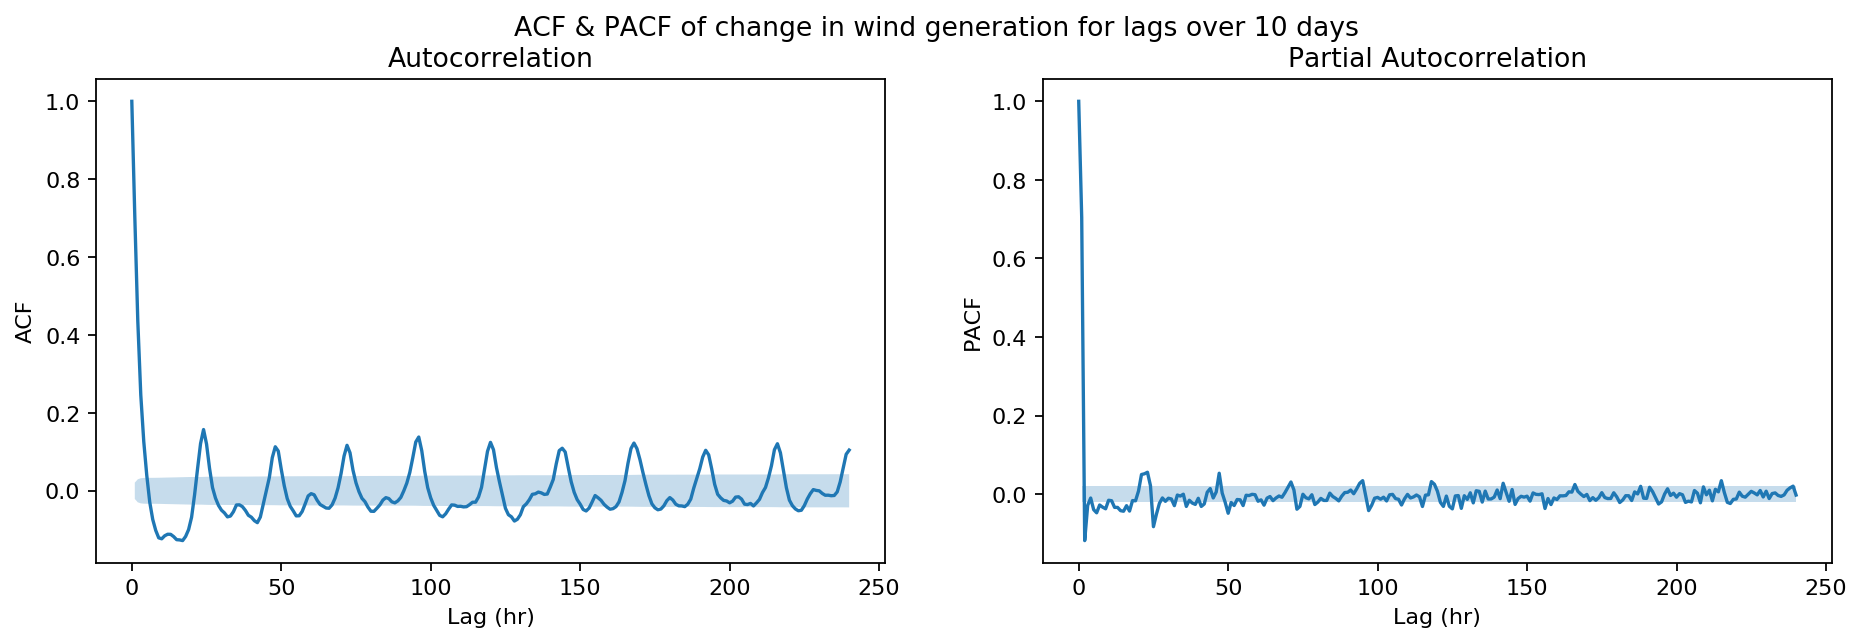

In [11]:
### ACF
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14,4),dpi=80)

ax = axes[0]
ax.set_xlabel('Lag (hr)')
ax.set_ylabel('ACF')

plotAcf = plot_acf(
    wind["Ramp"][1:],
    lags=240,
    alpha=0.05,
    ax=ax,
    use_vlines=False,
    markersize=0,
    linestyle='-')

### PACF
ax = axes[1]

ax.set_xlabel('Lag (hr)')
ax.set_ylabel('PACF')

plotAcf = plot_pacf(
    wind["Ramp"][1:],
    lags=240,
    alpha=0.05,
    ax=ax,
    use_vlines=False,
    markersize=0,
    linestyle='-')

fig.suptitle("ACF & PACF of change in wind generation for lags over 10 days")
plt.show()

### 7. 
Use a variance ratio test to investigate the structure of the wind generation time series. Can the null hypothesis of a random walk be rejected? Is there evidence of either mean-reversion of mean-aversion?

In [12]:
import vratiotest

y = wind["Generation"].values[1:]

vratio, pval = vratiotest.vratio(y, 2)

if vratio > 1:
    print(
        "Variance Ratio: vratio = {} (vratio>0.5)\n\tThe wind generation time series is mean-averting\n"
        .format(vratio))
elif vratio < 1:
    print(
        "Variance Ratio: vratio = {} (vratio<0.5)\n\tThe wind generation time series is mean-reverting\n"
        .format(vratio))
else:
    print(
        "Variance Ratio: vratio = {} (vratio=0.5)\n\tThe wind generation time series is a random walk\n"
        .format(vratio))

if pval < 0.0001:
    print((
        "P-value: p = 0.0000 (p<0.0000)\n\tNull hypothesis of a random walk is rejected for all confidence level\n"
    ))
elif pval <= 0.05:
    print(
        "P-value: p = {} (p<0.05)\n\tNull hypothesis of a random walk is rejected\n"
        .format(pval))
else:
    print(
        "P-value: p = {} (p>0.05)\n\tNull hypothesis of a random walk is not rejected\n"
        .format(pval))

Variance Ratio: vratio = 1.7043571476771524 (vratio>0.5)
	The wind generation time series is mean-averting

P-value: p = 0.0000 (p<0.0000)
	Null hypothesis of a random walk is rejected for all confidence level



### 8. 
Estimate the optimal window for simple moving average. Is there a simple benchmark that improves on the persistence benchmark?


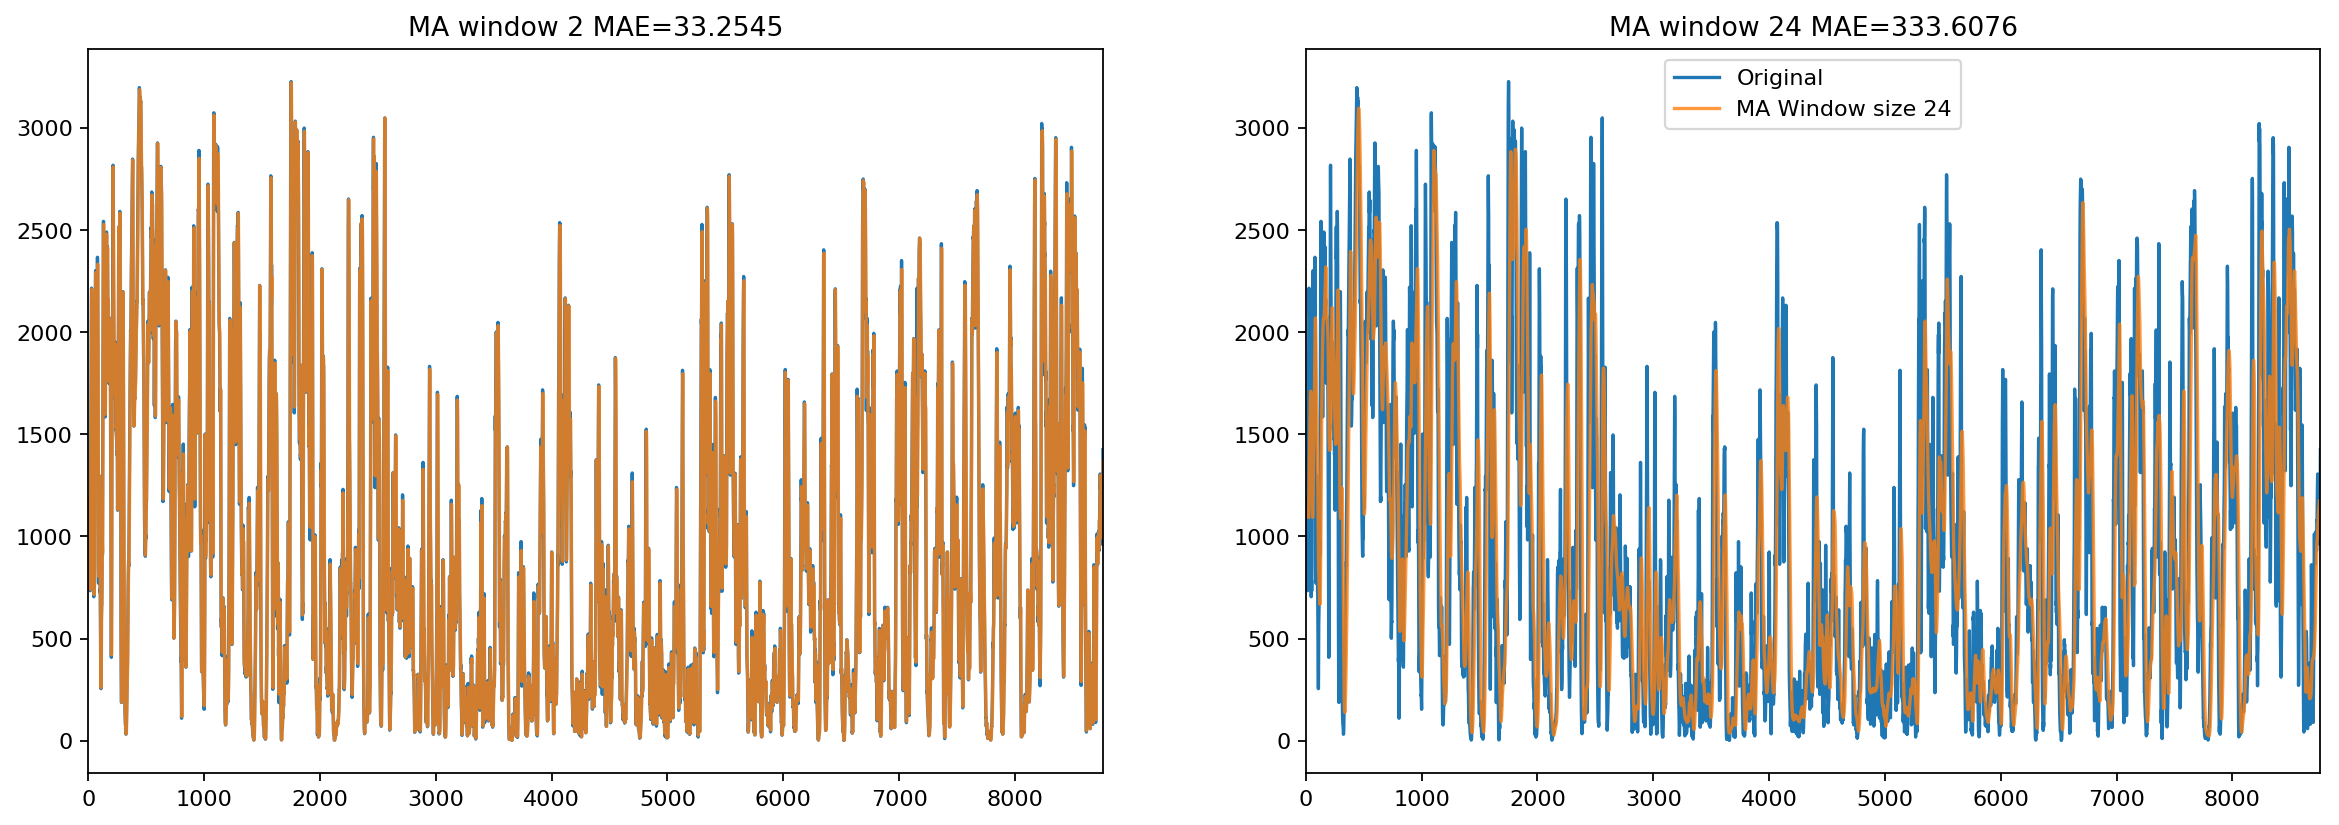

In [13]:
error = []
y = wind['Generation']
x = [i for i in range(1, N + 1)]

fig, axes = plt.subplots(
    nrows=1, ncols=2, sharex=True, figsize=(18, 6), dpi=80)

j = 0
for i in [2, 24]:
    _y = wind.Generation.rolling(i).mean()[i - 1:]
    _x = [i for i in range(i + 1, N + 2)]
    error.append(abs(_y[i:-1] - y[i + 1:]).mean())

    ax = axes[j]
    j += 1
    ax.plot(x, y, label="Original")
    ax.plot(_x, _y, label="MA Window size {}".format(i), alpha=0.8)

    ax.set_title("MA window {} MAE={}".format(
        i, round(abs(_y[i:-1] - y[i + 1:]).mean(), 4)))

ax.legend()
plt.xlim(1, N)
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

### persistence benchmark
perr = []
# print("Persistence Benchmark")
for i in range(0, 240):
    if i == 0:
        l = 0
    else:    
        l = mean_squared_error(y[i:].values, y[:-i].values)
    perr.append(l)
    
#     print("MSE k={}: {}".format(i,l))


/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


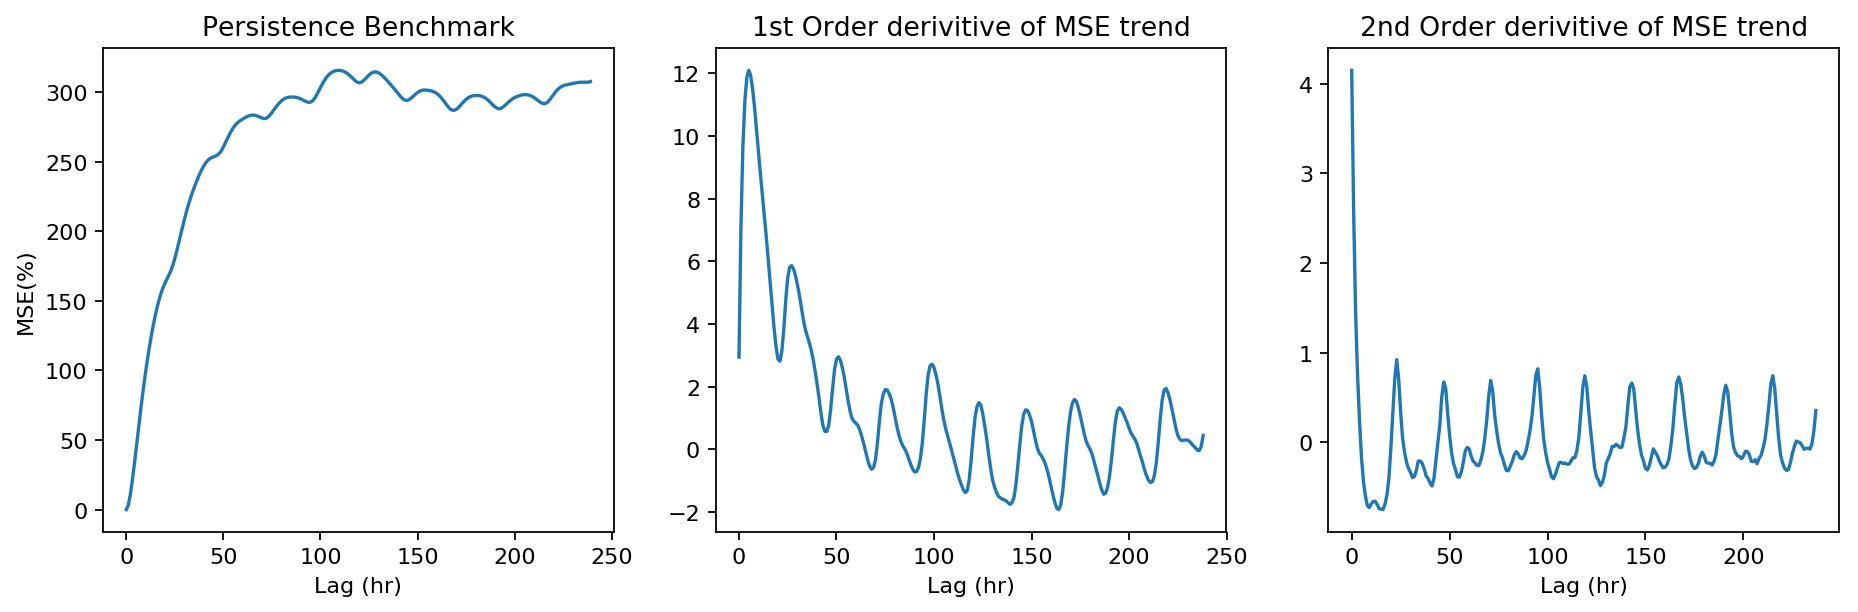

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4),dpi=80)

ax = axes[0]
ax.plot(range(0, 240), perr / y.max())

ax.set_xlabel('Lag (hr)')
ax.set_ylabel('MSE(%)')

ax.set_title("Persistence Benchmark")

###

d = [perr[i+1]-perr[i] for i in range(len(perr)-1)]
dd = [d[i+1]-d[i] for i in range(len(d)-1)]

ax = axes[1]

ax.plot(range(0, 239), d / y.max())

ax.set_xlabel('Lag (hr)')

ax.set_title("1st Order derivitive of MSE trend")

###
ax = axes[2]

ax.plot(range(0, 238), dd / y.max())

ax.set_xlabel('Lag (hr)')

ax.set_title("2nd Order derivitive of MSE trend")

plt.show()

### 9. 
Evaluate the mean-squared-error (MAE) performance of the persistence benchmark forecast over forecast horizons from one hour to one day. Plot MAE as a percentage of the maximum generation for the persistence benchmark.

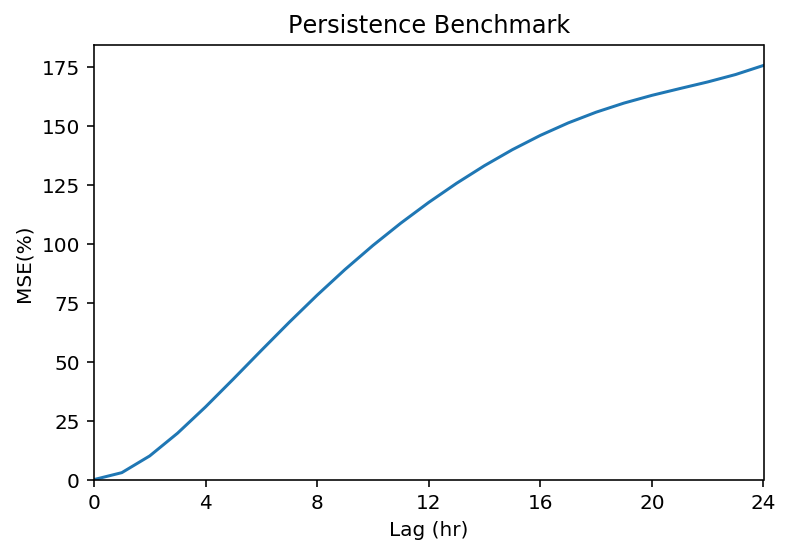

In [16]:
fig, ax = plt.subplots()

ax.plot(range(0, 25), perr[:25] / y.max())

ax.set_xlabel('Lag (hr)')
ax.set_ylabel('MSE(%)')

ax.set_title("Persistence Benchmark")

plt.xlim(0,24)
plt.xticks(range(0,25,4))
plt.ylim(0,plt.ylim()[1])
plt.show()

### 10. 
Loop over the number of parameters to use in an ARIMA model for describing wind generation and use information criteria (AIC and BIC) to find the optimal ARIMA model.

In [17]:
import statsmodels.api as sm
import itertools

warnings.filterwarnings("ignore")

y = wind['Generation']

p = q = range(0, 5)
d = range(1,2)
pdq = list(itertools.product(p, d, q))

aic = np.inf
for param in pdq:
    try:
        mdl = sm.tsa.statespace.SARIMAX(y,
                                        order=param,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mdl.fit()

        print('ARIMA{} - AIC:{}'.format(param, results.aic))
        if results.aic < aic:
            aic = results.aic
            mdlparam = param
    except:
        print('ARIMA{} - skipped'.format(param))
        continue

print("Selected model: ARIMA{} - AIC:{}".format(mdlparam, aic))

/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])


ARIMA(0, 1, 0) - AIC:105070.58431446314
ARIMA(0, 1, 1) - AIC:100697.99662308625
ARIMA(0, 1, 2) - AIC:99406.42062691608
ARIMA(0, 1, 3) - AIC:99068.62376508027
ARIMA(0, 1, 4) - AIC:98965.06043843979
ARIMA(1, 1, 0) - AIC:99076.02601647594
ARIMA(1, 1, 1) - AIC:98956.28738758202
ARIMA(1, 1, 2) - AIC:98932.31769955595
ARIMA(1, 1, 3) - AIC:98923.52319998141
ARIMA(1, 1, 4) - AIC:98912.68643914313
ARIMA(2, 1, 0) - AIC:98944.94654364204
ARIMA(2, 1, 1) - AIC:98835.73322517492
ARIMA(2, 1, 2) - AIC:98756.77119922655
ARIMA(2, 1, 3) - AIC:98744.83497891678
ARIMA(2, 1, 4) - AIC:98734.20657829988
ARIMA(3, 1, 0) - AIC:98929.64058522698
ARIMA(3, 1, 1) - AIC:98754.60223411451
ARIMA(3, 1, 2) - AIC:98755.56106699044
ARIMA(3, 1, 3) - AIC:98745.67819225705
ARIMA(3, 1, 4) - AIC:98736.03340552574
ARIMA(4, 1, 0) - AIC:98920.28360675901
ARIMA(4, 1, 1) - AIC:98923.15517798177
ARIMA(4, 1, 2) - AIC:98889.38194500534
ARIMA(4, 1, 3) - AIC:98745.24637812056
ARIMA(4, 1, 4) - AIC:98734.79728363133
Selected model: ARIMA(2

In [18]:
mdl = sm.tsa.statespace.SARIMAX(y,
                                order=mdlparam,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mdl.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6330      0.024     68.643      0.000       1.586       1.680
ar.L2         -0.6507      0.023    -28.032      0.000      -0.696      -0.605
ma.L1         -0.8700      0.025    -35.475      0.000      -0.918      -0.822
ma.L2         -0.1148      0.006    -19.018      0.000      -0.127      -0.103
ma.L3         -0.0319      0.012     -2.631      0.009      -0.056      -0.008
ma.L4          0.0193      0.015      1.322      0.186      -0.009       0.048
sigma2      4691.0884     21.783    215.352      0.000    4648.394    4733.783


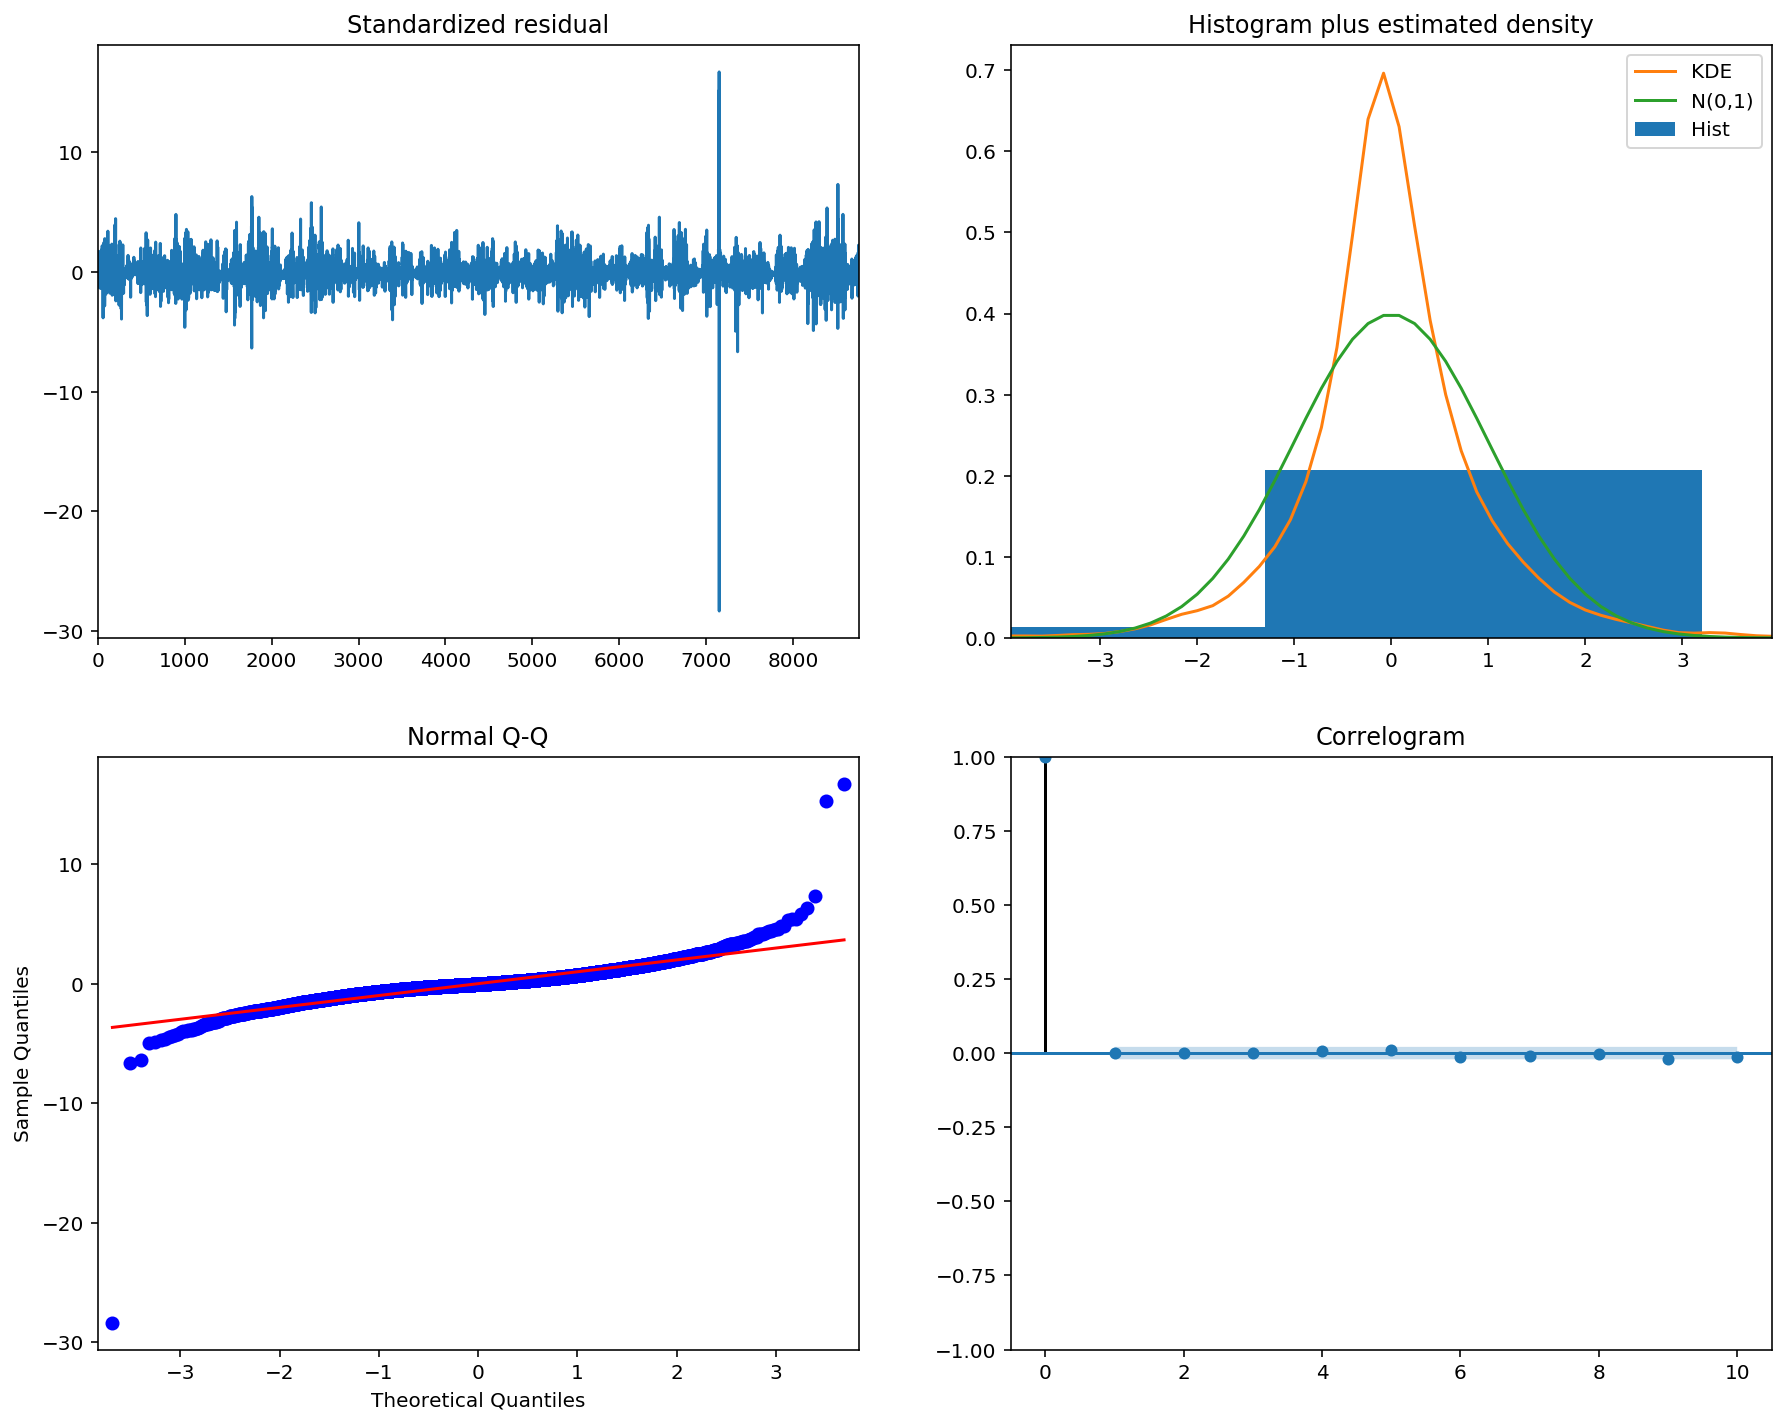

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()